In [100]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [101]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Set Up

In [102]:
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')  # start it
os.environ['DISPLAY']=':1.0'  # tells X clients where to connect to

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [103]:
!pip install keybert
!pip install KeyBERT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import pandas as pd
import random
import copy
from keybert import KeyBERT
import nltk
import re
import csv
from nltk import word_tokenize
import gensim.downloader as api

# Key Word Extraction

In [105]:
# Using BERT model to get to most valuable word from the answer, in this case the catagory or the mechanism
sw = ['boardgames', 'boardgame', 'theme', 'game', 'games', 'themes', 'set', 'atmosphere', 'topic', 'topics', 'mechanisms', 'mechanism']
kw_model = KeyBERT()

def extract_keyword(input_user):
    all_keywords = kw_model.extract_keywords(input_user, stop_words=sw)
    return all_keywords[0][0]

# Similarity Comparison

In [106]:
import csv

category_list = []  
mechanism_list = []


f = open("/content/drive/MyDrive/Colab_Notebooks/data/categories.csv")
category_list = list(csv.reader(f))

#for some reason bayes_rating shows up twice in this list
category_list.remove(['bayes_rating'])
category_list.remove(['bayes_rating'])

f.close


f = open("/content/drive/MyDrive/Colab_Notebooks/data/mechanisms.csv")
mechanism_list = list(csv.reader(f))

mechanism_list.remove(['bayes_rating'])
mechanism_list.remove(['rating'])

f.close

def lowercase (lst):
  new_lst = []
  for item in lst:
    temp_item = []
    for word in item:
      temp = word.lower()
      temp_item.append(temp)
    new_lst.append(temp_item)
  
  return new_lst

cat_list_lower = lowercase(category_list)
mech_list_lower = lowercase(mechanism_list)


In [107]:
import nltk
from nltk import word_tokenize
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
import re

stops = set(nltk.corpus.stopwords.words('english'))
common_tokens = ['game', 'games', ':', "'s",]


def tokenize (feature_list):
  
  temp_list = []

  for item in feature_list:
    word = item[0].replace('/', ' ')
    word = word.replace('-', ' ')
    word = word.replace('Minimap', 'mini map')
    
    temp_tokens = word_tokenize(word.lower())
    filtered = [w for w in temp_tokens 
                if not w in stops 
                and not w in common_tokens]

    temp_list.append(filtered)

  return temp_list


clean_cat = tokenize(category_list)
clean_mech = tokenize(mechanism_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') 

In [109]:
def user_to_features (feature_list, user_input, dataform_list):
  
  sim_list = []

  for feature in feature_list:
    average = 0
    for word in feature:
      try:
        sim_val = wv.similarity(word, user_input)
        average = average + sim_val
      except:
        average = 0

    average = average / len(feature)
    temp_tuple = (feature, average)
    sim_list.append(temp_tuple)
        
  sim_df = pd.DataFrame(sim_list, columns = ['word', 'sim']) 
  sim_df = sim_df.sort_values(by=['sim'], ascending=False)

  index = sim_df.index[0]

  stats = sim_df
  #print(stats)
  
  return (dataform_list[index], sim_df.iloc[0][1])

# Find Board Game

# Import User Data from Form

In [110]:
import pandas as pd
#defining my worksheet
worksheet = gc.open('Board Game Recommender Survey (Responses)').sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Convert to a DataFrame 
df = pd.DataFrame(rows)

#creating columns name
df.columns = df.iloc[0]
df = df.iloc[1:]

# Processing User Inputs

In [111]:
df.columns = ["timestamp",
              "email",
              "q1_sent",
              "q2_sent",
              "q3_sent",
              "q4_sent",
              "q5_sent",
              "q1_word",
              "q2_word",
              "q3_word",
              "q4_minplay",
              "q4_maxplay",
              "q5_mintime",
              "q5_maxtime"]

In [112]:
lst = []

for column in df.columns:
  temp_lst = df[column].tolist()
  lst.append(temp_lst)

print(lst)

[['5/26/2023 17:17:52', '5/26/2023 18:02:07', '5/27/2023 0:14:40', '5/27/2023 0:16:09', '5/27/2023 0:31:35', '5/27/2023 0:40:24', '5/27/2023 1:37:12', '5/27/2023 5:52:15', '5/28/2023 12:50:15', '5/28/2023 12:52:39', '5/28/2023 12:56:27', '5/28/2023 12:59:28', '5/28/2023 13:00:56', '5/28/2023 13:11:55', '5/28/2023 13:15:07', '5/28/2023 13:27:37', '5/28/2023 13:46:26', '5/28/2023 14:11:54', '5/28/2023 15:23:18', '5/28/2023 15:53:07', '5/28/2023 18:02:07', '5/29/2023 23:00:31', '5/30/2023 16:10:47'], ['schat160@umm.edu', 'joshdfrench@outlook.com', 'patrickdysart2@gmail.com', 'booth250@umn.edu', 'gerardtheplant@gmail.com', 'pusch030@umn.edu', 'smgiinthir@gmail.com', 'silve490@umn.edu', 'bejczyvera@gmail.com', '06-squad.protein@icloud.com', 'emma.beukers@hotmail.com', 'mathildepaquet19@gmail.com', 'clopro15@gmail.com', 'kjsdenotter@gmail.com', 'gayatri.srikant18@gmail.com', 'MateoAbrahami@outlook.com', 'sebastian@backtalk.com', 'laurehajislam7@gmail.com', 'paulavermaas@gmail.com', 'leihabin

In [113]:
def create_pairs(keyword_list, user_keyword_list):
  temp_lst = []
  i = 0
  while i < len(keyword_list):
    word = extract_keyword(keyword_list[i])
    temp_pair = (word, (word_tokenize(user_keyword_list[i].lower())[0]))
    temp_lst.append(temp_pair)
    i = i + 1

  return temp_lst

print(create_pairs(lst[2], lst[7]))


[('trains', 'trains'), ('classical', 'classical'), ('fantasy', 'medieval'), ('medieval', 'medieval'), ('castles', 'medieval'), ('spooky', 'horror'), ('space', 'space'), ('speak', 'tavern'), ('flowers', 'flowers'), ('nature', 'nature'), ('fantasy', 'fantasy'), ('fantasy', 'fantasy'), ('futuristic', 'futuristic'), ('forest', 'forrest'), ('setting', 'none'), ('land', 'fantasy'), ('fantasy', 'fantasy'), ('monarchy', 'monarchy'), ('city', 'city'), ('cartoon', 'cartoon'), ('space', 'space'), ('mystery', 'mystery'), ('fantasy', 'fantasy')]


In [114]:
def compare(feature_list, pair_list, dataform_list):
  lst = []
  sim_list = []
  for pair in pair_list:
    temp = []
    temp_sim = []
    for item in pair:
      word = (user_to_features(feature_list, item, dataform_list))[0]
      sim = (user_to_features(feature_list, item, dataform_list))[1]
      temp.append(word[0])
      temp_sim.append(sim)  
    lst.append(temp)
    sim_list.append(temp_sim)

  return (lst, sim_list)
    

In [115]:
def simple_sim(pair_list):
  sim_list = []
  for pair in pair_list:
    sim = wv.similarity(pair[0], pair[1])
    sim_list.append(sim)
  
  return sim_list

In [116]:
def find_dif(pair_list):
  dif_list = []
  for pair in pair_list:
    dif = pair[0] - pair[1]
    dif_list.append(dif)

  return dif_list

In [117]:
pairs = create_pairs(lst[2], lst[7])

compare(clean_cat, pairs, cat_list_lower)

([['trains', 'trains'],
  ['music', 'music'],
  ['fantasy', 'medieval'],
  ['medieval', 'medieval'],
  ['medieval', 'medieval'],
  ['horror', 'horror'],
  ['space exploration', 'space exploration'],
  ['word game', 'family games'],
  ['animals', 'animals'],
  ['animals', 'animals'],
  ['fantasy', 'fantasy'],
  ['fantasy', 'fantasy'],
  ['fantasy', 'fantasy'],
  ['farming', 'fantasy'],
  ['city building', 'number'],
  ['territory building', 'fantasy'],
  ['fantasy', 'fantasy'],
  ['napoleonic', 'napoleonic'],
  ['city building', 'city building'],
  ['horror', 'horror'],
  ['space exploration', 'space exploration'],
  ['murder/mystery', 'murder/mystery'],
  ['fantasy', 'fantasy']],
 [[1.0000001192092896, 1.0000001192092896],
  [0.6977477073669434, 0.6977477073669434],
  [1.0, 1.0],
  [1.0, 1.0],
  [0.6006653904914856, 1.0],
  [0.4482521116733551, 1.0],
  [0.7824932634830475, 0.7824932634830475],
  [0.6408417820930481, 0.3250132203102112],
  [0.42256033420562744, 0.42256033420562744],
  [

In [118]:
def if_same(pair_list):
  same_list = []
  for pair in pair_list:
    if pair[0] == pair[1]:
      same_list.append(1)
    else: 
      same_list.append(0)
  return same_list

In [119]:
#Category 1
cat1_pairs = create_pairs(lst[2], lst[7])
keyword_sim_cat1 = simple_sim(cat1_pairs)
feature_cat1 = (compare(clean_cat, cat1_pairs, cat_list_lower))[0]
sim_compare_cat1 = (compare(clean_cat, cat1_pairs, cat_list_lower))[1]
feature_same_cat1 = if_same(feature_cat1)

print(sim_compare_cat1)
print(find_dif(sim_compare_cat1))

print(keyword_sim_cat1)
print(feature_cat1)
print(feature_same_cat1)

#Category 2
cat2_pairs = create_pairs(lst[3], lst[8])
keyword_sim_cat2 = simple_sim(cat2_pairs)
feature_cat2 = (compare(clean_cat, cat2_pairs, cat_list_lower))[0]
sim_compare_cat2 = (compare(clean_cat, cat2_pairs, cat_list_lower))[1]
feature_same_cat2 = if_same(feature_cat2)

#Mechanism
mech_pairs = create_pairs(lst[4], lst[9])
keyword_sim_mech = simple_sim(mech_pairs)
feature_mech = (compare(clean_mech, mech_pairs, mech_list_lower))[0]
sim_compare_mech = (compare(clean_mech, mech_pairs, mech_list_lower))[1]
feature_same_mech = if_same(feature_mech)

[[1.0000001192092896, 1.0000001192092896], [0.6977477073669434, 0.6977477073669434], [1.0, 1.0], [1.0, 1.0], [0.6006653904914856, 1.0], [0.4482521116733551, 1.0], [0.7824932634830475, 0.7824932634830475], [0.6408417820930481, 0.3250132203102112], [0.42256033420562744, 0.42256033420562744], [0.6022692918777466, 0.6022692918777466], [1.0, 1.0], [1.0, 1.0], [0.5461805462837219, 0.5461805462837219], [0.49102380871772766, 0.2700617015361786], [0.5884629487991333, 0.6382914185523987], [0.6203604340553284, 1.0], [1.0, 1.0], [0.4877975285053253, 0.4877975285053253], [0.8194020390510559, 0.8194020390510559], [0.5911517143249512, 0.5911517143249512], [0.7824932634830475, 0.7824932634830475], [0.7356105744838715, 0.7356105744838715], [1.0, 1.0]]
[0.0, 0.0, 0.0, 0.0, -0.3993346095085144, -0.5517478883266449, 0.0, 0.3158285617828369, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22096210718154907, -0.04982846975326538, -0.37963956594467163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0000001, 1.0, 0.37800744, 1.0, 0.600665

In [120]:
#Adding to the dataframe

#Category 1
df["Theme Similarity"] = keyword_sim_cat1
df["correct cat1"] = feature_same_cat1
df["Difference in Theme Similarity"] = find_dif(sim_compare_cat1)

#Category 2
df["Type Similarity"] = keyword_sim_cat2
df["correct cat2"] = feature_same_cat2
df["Difference in Type Similarity"] = find_dif(sim_compare_cat2)

#Mechanism
df["Mechanism Similarity"] = keyword_sim_mech
df["correct mech"] = feature_same_mech
df["Difference in Mechanism Similarity"] = find_dif(sim_compare_mech)

print(df)

             timestamp                        email  \
1   5/26/2023 17:17:52             schat160@umm.edu   
2   5/26/2023 18:02:07      joshdfrench@outlook.com   
3    5/27/2023 0:14:40     patrickdysart2@gmail.com   
4    5/27/2023 0:16:09             booth250@umn.edu   
5    5/27/2023 0:31:35     gerardtheplant@gmail.com   
6    5/27/2023 0:40:24             pusch030@umn.edu   
7    5/27/2023 1:37:12         smgiinthir@gmail.com   
8    5/27/2023 5:52:15             silve490@umn.edu   
9   5/28/2023 12:50:15         bejczyvera@gmail.com   
10  5/28/2023 12:52:39  06-squad.protein@icloud.com   
11  5/28/2023 12:56:27     emma.beukers@hotmail.com   
12  5/28/2023 12:59:28   mathildepaquet19@gmail.com   
13  5/28/2023 13:00:56           clopro15@gmail.com   
14  5/28/2023 13:11:55        kjsdenotter@gmail.com   
15  5/28/2023 13:15:07  gayatri.srikant18@gmail.com   
16  5/28/2023 13:27:37    MateoAbrahami@outlook.com   
17  5/28/2023 13:46:26       sebastian@backtalk.com   
18  5/28/2

# Data Processing

[]

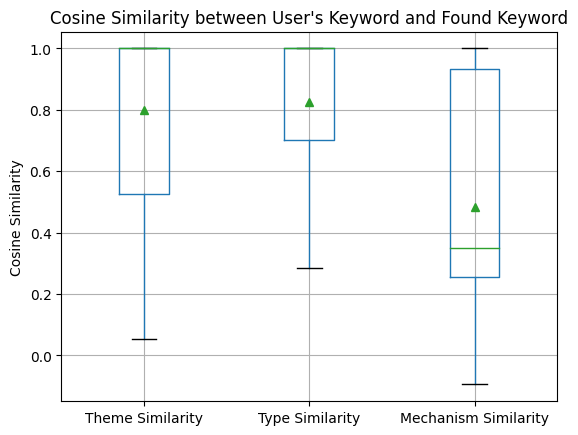

In [121]:
import matplotlib.pyplot as plt

b_plot = df.boxplot(column = ["Theme Similarity", "Type Similarity", 
                              "Mechanism Similarity"], 
                    showmeans = True)

b_plot.set_title("Cosine Similarity between User's Keyword and Found Keyword")

b_plot.set_ylabel("Cosine Similarity")

b_plot.plot()



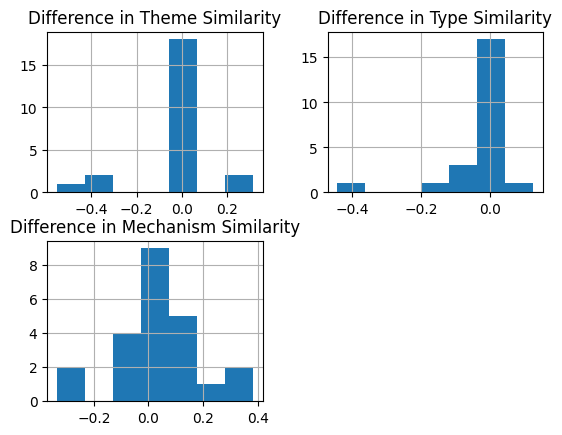

In [122]:
hist = df.hist(column = ["Difference in Theme Similarity", "Difference in Type Similarity", 
                              "Difference in Mechanism Similarity"], bins=7)


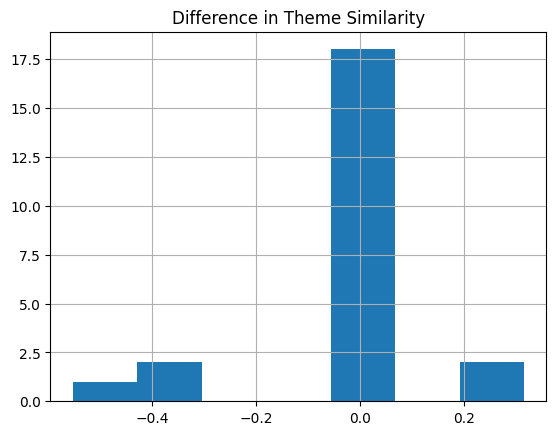

In [123]:
hist = df.hist(column = ["Difference in Theme Similarity"], bins=7)

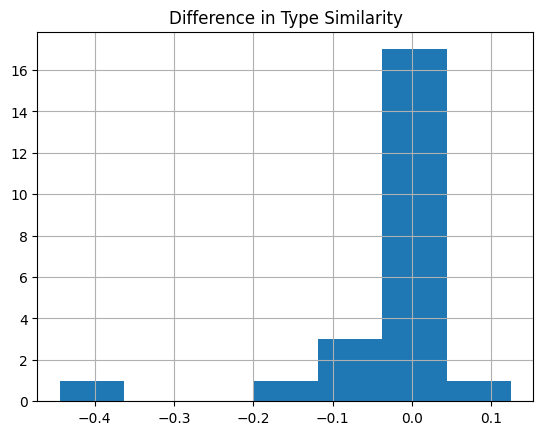

In [124]:
hist = df.hist(column = ["Difference in Type Similarity"], bins=7)

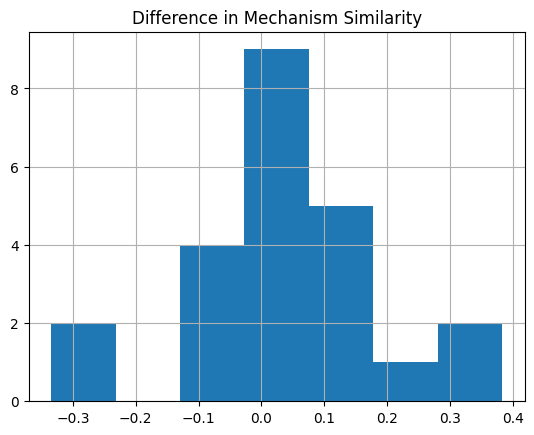

In [125]:
hist = df.hist(column = ["Difference in Mechanism Similarity"], bins=7)

In [126]:
def find_accuracy(same_list):
  sum = 0
  for item in same_list:
    sum = sum + item
  sum = sum / len(same_list)

  return sum

In [127]:
print(find_accuracy(feature_same_cat1))

print(find_accuracy(feature_same_cat2))

print(find_accuracy(feature_same_mech))


0.782608695652174
0.7391304347826086
0.34782608695652173
